# Learning to Reweight Examples for Robust Deep Learning

In [55]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from model import *
from data_loader import *
import matplotlib.pyplot as plt
from tqdm import tqdm
import IPython
import gc
import matplotlib
matplotlib.rcParams.update({'errorbar.capsize': 5})

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
hyperparameters = {
    'lr' : 1e-3,
    'momentum' : 0.9,
    'batch_size' : 100,
    'num_iterations' : 8000,
}

### Dataset
Following the class imbalance experiment in the paper, we used numbers 9 and 4 of the MNIST dataset to form a highly imbalanced dataset where 9 is the dominating class. The test set on the other hand is balanced.

In [3]:
data_loader = get_mnist_loader(hyperparameters['batch_size'], classes=[9, 4], proportion=0.995, mode="train")
test_loader = get_mnist_loader(hyperparameters['batch_size'], classes=[9, 4], proportion=0.5, mode="test")

Processing...
Done!


In [57]:
def to_var(x, requires_grad=True):
    if torch.cuda.is_available():
        x = x.cuda()
    return Variable(x, requires_grad=requires_grad)

#### Since the validation data is small (only 10 examples) there is no need to wrap it in a dataloader

In [48]:
val_data = to_var(data_loader.dataset.data_val, requires_grad=False)
val_labels = to_var(data_loader.dataset.labels_val, requires_grad=False)

print one batch of data to see if the train data is really imbalanced and if the test data is balanced.

In [58]:
for i,(img, label) in enumerate(data_loader):
    print(img.size(),label)
    break

torch.Size([100, 1, 32, 32]) tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 0., 1., 1., 1., 1., 0., 1.])


In [7]:
for i,(img, label) in enumerate(test_loader):
    print(img.size(),label)
    break

torch.Size([100, 1, 32, 32]) tensor([ 0.,  1.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  1.,
         0.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  0.,  1.,
         1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  1.,  0.,
         1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  1.,  0.,
         1.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.,  0.,
         0.,  1.,  0.,  1.,  1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,
         1.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,
         1.,  1.,  1.,  1.])


In [59]:
def build_model():
    net = LeNet(n_out=1)

    if torch.cuda.is_available():
        net.cuda()
        torch.backends.cudnn.benchmark=True

    opt = torch.optim.SGD(net.params(),lr=hyperparameters["lr"])
    
    return net, opt

## Baseline Model
I trained a LeNet model for the MNIST data without weighting the loss as a baseline model for comparison.

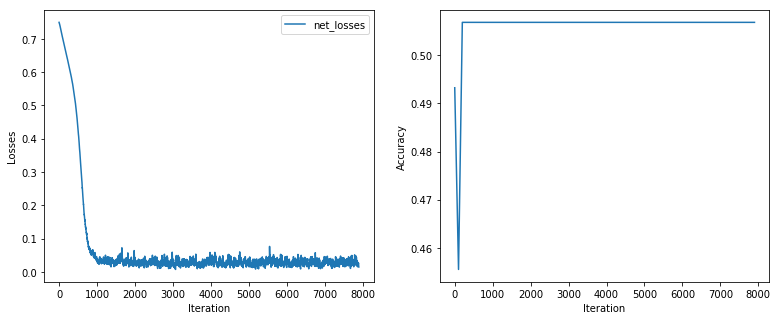

100%|██████████████████████████████████████████████████████████████████████████████| 8000/8000 [10:09<00:00, 15.73it/s]


In [10]:
net, opt = build_model()

net_losses = []
plot_step = 100
net_l = 0

smoothing_alpha = 0.9
accuracy_log = []
for i in tqdm(range(hyperparameters['num_iterations'])):
    net.train()
    image, labels = next(iter(data_loader))

    image = to_var(image, requires_grad=False)
    labels = to_var(labels, requires_grad=False)

    y = net(image)
    cost = F.binary_cross_entropy_with_logits(y, labels)
    
    opt.zero_grad()
    cost.backward()
    opt.step()
    
    net_l = smoothing_alpha *net_l + (1 - smoothing_alpha)* cost.item()
    net_losses.append(net_l/(1 - smoothing_alpha**(i+1)))
    
    if i % plot_step == 0:
        net.eval()
        
        acc = []
        for itr,(test_img, test_label) in enumerate(test_loader):
            test_img = to_var(test_img, requires_grad=False)
            test_label = to_var(test_label, requires_grad=False)
            
            output = net(test_img)
            predicted = (F.sigmoid(output) > 0.5).int()
            
            acc.append((predicted.int() == test_label.int()).float())

        accuracy = torch.cat(acc,dim=0).mean()
        accuracy_log.append(np.array([i,accuracy])[None])
        
        
        IPython.display.clear_output()
        fig, axes = plt.subplots(1, 2, figsize=(13,5))
        ax1, ax2 = axes.ravel()

        ax1.plot(net_losses, label='net_losses')
        ax1.set_ylabel("Losses")
        ax1.set_xlabel("Iteration")
        ax1.legend()
        
        acc_log = np.concatenate(accuracy_log, axis=0)
        ax2.plot(acc_log[:,0],acc_log[:,1])
        ax2.set_ylabel('Accuracy')
        ax2.set_xlabel('Iteration')
        plt.show()

As expected, due to the heavily imbalanced training data, the network could not learn how to differentiate between 9 and 4.

## Learning to Reweight Examples 
Below is a pseudocode of the method proposed in the paper. It is very straightforward.

<img src="pseudocode.PNG" width="300" />



In [60]:
def train_lre2():
    net, opt = build_model()
    
    meta_losses_clean = []
    net_losses = []
    plot_step = 100

    smoothing_alpha = 0.9
    
    meta_l = 0
    net_l = 0
    accuracy_log = []
    for i in tqdm(range(hyperparameters['num_iterations'])):
        net.train()
        # Line 2 get batch of data
        image, labels = next(iter(data_loader))
        image = to_var(image, requires_grad=False)
        labels = to_var(labels, requires_grad=False)

        # Lines 4 - 5 initial forward pass to compute the initial weighted loss
        y_f_hat  = net(image)
        cost = F.binary_cross_entropy_with_logits(y_f_hat,labels, reduce=False)
        eps = to_var(torch.zeros(y_f_hat.size()))
        l_f_meta = torch.sum(cost * eps)

        net.zero_grad()
        
        # Line 6 perform a parameter update
        grads = torch.autograd.grad(l_f_meta, (net.params()), create_graph=True, retain_graph=True)
        net.update_params(hyperparameters['lr'], source_params=grads)
        
        # Line 8 - 10 2nd forward pass and getting the gradients with respect to epsilon
        y_g_hat = net(val_data)

        l_g_meta = F.binary_cross_entropy_with_logits(y_g_hat,val_labels)

        grad_eps = torch.autograd.grad(l_g_meta, eps, only_inputs=True, retain_graph=True)[0]
        
        # Line 11 computing and normalizing the weights
        w_tilde = torch.clamp(-grad_eps,min=0)
        norm_c = torch.sum(w_tilde)

        if norm_c != 0:
            w = w_tilde / norm_c
        else:
            w = w_tilde

        # Lines 12 - 14 computing for the loss with the computed weights
        # and then perform a parameter update
        y_f_hat = net(image)
        cost = F.binary_cross_entropy_with_logits(y_f_hat, labels, reduce=False)
        l_f = torch.sum(cost * w)

        opt.zero_grad()
        l_f.backward()
        opt.step()

        meta_l = smoothing_alpha *meta_l + (1 - smoothing_alpha)* l_g_meta.item()
        meta_losses_clean.append(meta_l/(1 - smoothing_alpha**(i+1)))

        net_l = smoothing_alpha *net_l + (1 - smoothing_alpha)* l_f.item()
        net_losses.append(net_l/(1 - smoothing_alpha**(i+1)))

        if i % plot_step == 0:
            net.eval()

            acc = []
            for itr,(test_img, test_label) in enumerate(test_loader):
                test_img = to_var(test_img, requires_grad=False)
                test_label = to_var(test_label, requires_grad=False)

                output = net(test_img)
                predicted = (F.sigmoid(output) > 0.5).int()

                acc.append((predicted.int() == test_label.int()).float())

            accuracy = torch.cat(acc,dim=0).mean()
            accuracy_log.append(np.array([i,accuracy])[None])


            IPython.display.clear_output()
            fig, axes = plt.subplots(1, 2, figsize=(13,5))
            ax1, ax2 = axes.ravel()

            ax1.plot(meta_losses_clean, label='meta_losses_clean')
            ax1.plot(net_losses, label='net_losses')
            ax1.set_ylabel("Losses")
            ax1.set_xlabel("Iteration")
            ax1.legend()

            acc_log = np.concatenate(accuracy_log, axis=0)
            ax2.plot(acc_log[:,0],acc_log[:,1])
            ax2.set_ylabel('Accuracy')
            ax2.set_xlabel('Iteration')
            plt.show()
            
        # return accuracy
    return np.mean(acc_log[-6:-1, 1])

In [61]:
def train_lre():
    net, opt = build_model()
    
    meta_losses_clean = []
    net_losses = []
    plot_step = 100

    smoothing_alpha = 0.9
    
    meta_l = 0
    net_l = 0
    accuracy_log = []
    for i in tqdm(range(hyperparameters['num_iterations'])):
        net.train()
        # Line 2 get batch of data
        image, labels = next(iter(data_loader))
        # since validation data is small I just fixed them instead of building an iterator
        # initialize a dummy network for the meta learning of the weights
        meta_net = LeNet(n_out=1)
        meta_net.load_state_dict(net.state_dict())

        if torch.cuda.is_available():
            meta_net.cuda()

        image = to_var(image, requires_grad=False)
        labels = to_var(labels, requires_grad=False)

        # Lines 4 - 5 initial forward pass to compute the initial weighted loss
        y_f_hat  = meta_net(image)
        cost = F.binary_cross_entropy_with_logits(y_f_hat,labels, reduce=False)
        eps = to_var(torch.zeros(y_f_hat.size()))
        l_f_meta = torch.sum(cost * eps)

        meta_net.zero_grad()
        
        # Line 6 perform a parameter update
        grads = torch.autograd.grad(l_f_meta, (meta_net.params()), create_graph=True)
        meta_net.update_params(hyperparameters['lr'], source_params=grads)
        
        # Line 8 - 10 2nd forward pass and getting the gradients with respect to epsilon
        y_g_hat = meta_net(val_data)

        l_g_meta = F.binary_cross_entropy_with_logits(y_g_hat,val_labels)

        grad_eps = torch.autograd.grad(l_g_meta, eps, only_inputs=True)[0]
        
        # Line 11 computing and normalizing the weights
        w_tilde = torch.clamp(-grad_eps,min=0)
        norm_c = torch.sum(w_tilde)

        if norm_c != 0:
            w = w_tilde / norm_c
        else:
            w = w_tilde

        # Lines 12 - 14 computing for the loss with the computed weights
        # and then perform a parameter update
        y_f_hat = net(image)
        cost = F.binary_cross_entropy_with_logits(y_f_hat, labels, reduce=False)
        l_f = torch.sum(cost * w)

        opt.zero_grad()
        l_f.backward()
        opt.step()

        meta_l = smoothing_alpha *meta_l + (1 - smoothing_alpha)* l_g_meta.item()
        meta_losses_clean.append(meta_l/(1 - smoothing_alpha**(i+1)))

        net_l = smoothing_alpha *net_l + (1 - smoothing_alpha)* l_f.item()
        net_losses.append(net_l/(1 - smoothing_alpha**(i+1)))

        if i % plot_step == 0:
            net.eval()

            acc = []
            for itr,(test_img, test_label) in enumerate(test_loader):
                test_img = to_var(test_img, requires_grad=False)
                test_label = to_var(test_label, requires_grad=False)

                output = net(test_img)
                predicted = (F.sigmoid(output) > 0.5).int()

                acc.append((predicted.int() == test_label.int()).float())

            accuracy = torch.cat(acc,dim=0).mean()
            accuracy_log.append(np.array([i,accuracy])[None])


            IPython.display.clear_output()
            fig, axes = plt.subplots(1, 2, figsize=(13,5))
            ax1, ax2 = axes.ravel()

            ax1.plot(meta_losses_clean, label='meta_losses_clean')
            ax1.plot(net_losses, label='net_losses')
            ax1.set_ylabel("Losses")
            ax1.set_xlabel("Iteration")
            ax1.legend()

            acc_log = np.concatenate(accuracy_log, axis=0)
            ax2.plot(acc_log[:,0],acc_log[:,1])
            ax2.set_ylabel('Accuracy')
            ax2.set_xlabel('Iteration')
            plt.show()
            
        # return accuracy
    return np.mean(acc_log[-6:-1, 1])

To get an idea of how robust this method is with respect to the proportion of the dominant class, I varied the proportion from 0.9 to 0.995 and perform 5 runs for each. 

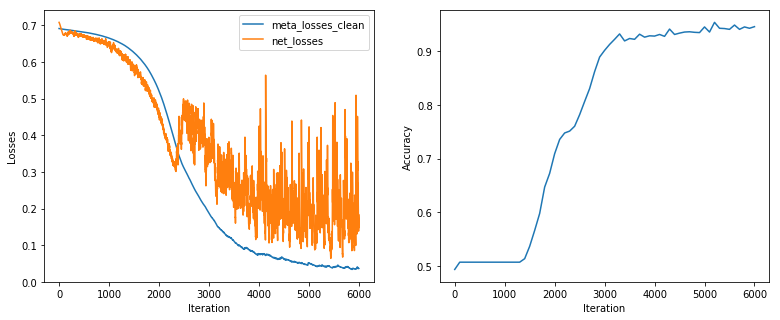




 75%|██████████████████████████████████████████████████████████▌                   | 6001/8000 [20:11<34:45,  1.04s/it]


 75%|██████████████████████████████████████████████████████████▌                   | 6002/8000 [20:12<31:04,  1.07it/s]


 75%|██████████████████████████████████████████████████████████▌                   | 6003/8000 [20:13<28:05,  1.18it/s]


 75%|██████████████████████████████████████████████████████████▌                   | 6004/8000 [20:13<28:05,  1.18it/s]


 75%|██████████████████████████████████████████████████████████▌                   | 6005/8000 [20:14<24:18,  1.37it/s]


 75%|██████████████████████████████████████████████████████████▌                   | 6006/8000 [20:14<21:30,  1.55it/s]


 75%|██████████████████████████████████████████████████████████▌                   | 6007/8000 [20:15<20:22,  1.63it/s]


 75%|██████████████████████████████████████████████████████████▌                   | 6008/8000 [20:16<21:08,  1.57it/s]


 75%|████████████████

 76%|███████████████████████████████████████████████████████████▏                  | 6068/8000 [20:43<13:12,  2.44it/s]


 76%|███████████████████████████████████████████████████████████▏                  | 6069/8000 [20:43<12:32,  2.57it/s]


 76%|███████████████████████████████████████████████████████████▏                  | 6070/8000 [20:44<13:12,  2.43it/s]


 76%|███████████████████████████████████████████████████████████▏                  | 6071/8000 [20:44<14:10,  2.27it/s]


 76%|███████████████████████████████████████████████████████████▏                  | 6072/8000 [20:45<15:25,  2.08it/s]


 76%|███████████████████████████████████████████████████████████▏                  | 6073/8000 [20:45<14:59,  2.14it/s]


 76%|███████████████████████████████████████████████████████████▏                  | 6074/8000 [20:46<16:59,  1.89it/s]


 76%|███████████████████████████████████████████████████████████▏                  | 6075/8000 [20:47<16:15,  1.97it/s]


 76%|███████████████████

In [ ]:
num_repeats = 5
weights = [[0.9,0.1], [0.95, 0.05], [0.98, 0.02], [0.99, 0.01], [0.995, 0.005]]
#proportions = [0.9,0.95, 0.98, 0.99, 0.995]
accuracy_log = {}

for ind, weight in enumerate(weights):
    data_loader = get_mnist_loader(hyperparameters['batch_size'], classes=[9, 4], weights=weight, mode="train")
    val_data = to_var(data_loader.dataset.data_val, requires_grad=False)
    val_labels = to_var(data_loader.dataset.labels_val, requires_grad=False)
    
    for k in range(num_repeats):
        accuracy = train_lre()
        
        if prop in accuracy_log:
            accuracy_log[ind].append(accuracy)
        else:
            accuracy_log[ind] = [accuracy]

plt.figure(figsize=(10,8))
for ind, _ in enumerate(weights):
    accuracies = accuracy_log[ind]
    plt.scatter([ind] * len(accuracies), accuracies)

# plot the trend line with error bars that correspond to standard deviation
accuracies_mean = np.array([np.mean(v) for k,v in sorted(accuracy_log.items())])
accuracies_std = np.array([np.std(v) for k,v in sorted(accuracy_log.items())])
plt.errorbar(proportions, accuracies_mean, yerr=accuracies_std)
plt.title('Performance on varying class proportions')
plt.xlabel('proportions')
plt.ylabel('Accuracy')
plt.show()

We can see that even at 0.995 proportion of the dominant class in the training data, the model still reaches 90+% accuracy on the balanced test data.